# Data Prepration

*Reading the data and convert them to DFs*

In [881]:
import numpy as np
import pandas as pd

users_df = pd.read_csv('users.csv')
restaurants_df = pd.read_csv('restaurants.csv')
suppliers_df = pd.read_csv('suppliers.csv')
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')

DFs = [users_df,restaurants_df,suppliers_df,orders_df,products_df]


# Cleaning data

**Handling Duplicates**

In [882]:
def CheckDuplicates(dfs):
    for  i, dfs in enumerate(dfs): 
        duplicate = dfs.duplicated().sum()
        print('The dataset contained {} duplicated rows'.format(duplicate))
        if(duplicate > 0):
            dfs = dfs.drop_duplicates()

In [883]:
CheckDuplicates(DFs)

The dataset contained 0 duplicated rows
The dataset contained 0 duplicated rows
The dataset contained 0 duplicated rows
The dataset contained 0 duplicated rows
The dataset contained 0 duplicated rows


In [884]:
# Remove duplicates
users_df.drop_duplicates(inplace=True)
restaurants_df.drop_duplicates(inplace=True)
suppliers_df.drop_duplicates(inplace=True)
orders_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)

**Handling Missings**

checkMissings Mehtod check the percentage of missings in each DataFrame 
- if the rows contibute to the datasert is less than 1% then it's safe to drop them.

In [885]:
def checkMissings(dfs):
    for  i, dfs in enumerate(dfs): 
        columns_with_missing_values = dfs.columns[dfs.isna().any()]
        columns_to_drop = dfs[columns_with_missing_values].isna().mean() * 100
        columns_to_drop = columns_to_drop[columns_to_drop < 1]
        total_rows = dfs[columns_to_drop.index] \
        .isna().any(axis=1).sum()
        percentage = (total_rows / dfs.shape[0]) * 100
        print('***************')
        print(f"Missing percentage for DataFrame {i}:")
        print('Total number of rows: ', total_rows)
        print('These rows contribute to the dataset with {percentage:.2f}%'.format(percentage=percentage))

In [886]:
checkMissings(DFs)

***************
Missing percentage for DataFrame 0:
Total number of rows:  0
These rows contribute to the dataset with 0.00%
***************
Missing percentage for DataFrame 1:
Total number of rows:  0
These rows contribute to the dataset with 0.00%
***************
Missing percentage for DataFrame 2:
Total number of rows:  0
These rows contribute to the dataset with 0.00%
***************
Missing percentage for DataFrame 3:
Total number of rows:  0
These rows contribute to the dataset with 0.00%
***************
Missing percentage for DataFrame 4:
Total number of rows:  0
These rows contribute to the dataset with 0.00%


In [887]:
#Remove rows with missing values
users_df.dropna(inplace=True)
restaurants_df.dropna(inplace=True)
suppliers_df.dropna(inplace=True)
orders_df.dropna(inplace=True)
products_df.dropna(inplace=True)

convert the order_date and delivery_data to Date format

In [888]:
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%d/%m/%Y')
orders_df["delivery_date"] = pd.to_datetime(orders_df["delivery_date"], format='%d/%m/%Y')
orders_df['order_month'] = orders_df['order_date'].apply(lambda x: x.month)
orders_df['order_year'] = orders_df['order_date'].apply(lambda x: x.year)


Rename columns for consistency


In [889]:
users_df.rename(columns={"id": "user_id"}, inplace=True)
restaurants_df.rename(columns={"id": "restaurant_id"}, inplace=True)
suppliers_df.rename(columns={"id": "supplier_id"}, inplace=True)
products_df.rename(columns={"id": "product_id"}, inplace=True)

# Features Engineering

**Number of orders_df**

num_orders_df is the total number of orders_df has been made of a product

In [890]:
#Add total number of orders_df of a specfic product
num_orders_df = orders_df.groupby('product_id')['order_id'].nunique().reset_index()
num_orders_df = num_orders_df.rename(columns={'order_id': 'num_orders_df'}).astype('Int16') #convert it to Integer value not float
products_df = products_df.merge(num_orders_df, on='product_id', how='left')

products_df['num_orders_df'] = products_df['num_orders_df'].fillna(0) #remove NaNs



**Product Rating** 

product_rating is resturant rating for a specfic product it has the value from 1 to 5 this value has been calculated with this assumption:
- if the product has not been ordered before the rating will be 0 
- if the product has been ordered 1, 2 or 3 times the rating will be between 1:3
- if the product has been ordered < 3 then the rating will be 4 or 5 

Notice: 
this is assumption is made by me

In [891]:
def assign_product_rating(num_orders_df):
    if num_orders_df == 0:
        return 0
    elif num_orders_df <= 3:
        return np.random.choice([1, 2, 3])
    else:
        return np.random.choice([4, 5])

# Add product_rating column to products_df based on num_orders_df
products_df['product_rating'] = products_df['num_orders_df'].apply(assign_product_rating)




**Order for supplier**

supplier_num_orders refers to the total number of orders_df requested by resturants from specfic supplier

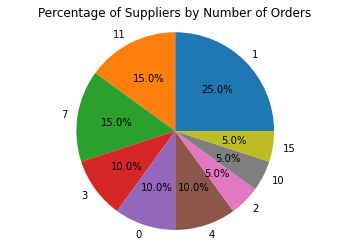

In [892]:
#Add total number of orders_df of specfic supplier
# Group orders_df by supplier and count unique order IDs
# Get the total number of orders_df for each supplier
num_orders_df = orders_df.merge(products_df, on='product_id', how='left')
num_orders_df = num_orders_df.groupby('supplier_id')['order_id'].nunique().reset_index()
num_orders_df = num_orders_df.rename(columns={'order_id': 'supplier_num_orders'}).astype('Int16')

# Merge with suppliers_df
suppliers_df = suppliers_df.merge(num_orders_df, on='supplier_id', how='left').fillna(0)

import matplotlib.pyplot as plt

# Calculate the percentage of suppliers that made a certain number of orders
order_counts = suppliers_df['supplier_num_orders'].value_counts(normalize=True) * 100



labels = order_counts.index.astype(str)
sizes = order_counts.values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Percentage of Suppliers by Number of Orders')
plt.show()


**Delivery performance**

delivery_performance calcualtes the performance of every supplier depending on orders_df as following:
- if the delivery date - order date  > lead days then the supplier's performance (late) 
- if the delivery date - order date  < lead days then the supplier's performance (early)
- if the delivery date - order date  = lead days then the supplier's performance (on Time)

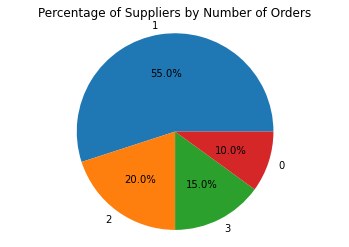

In [893]:
# Merge orders_df, products_df, and suppliers_df to get the delivery lead time and supplier_id for each order
merged_df = pd.merge(orders_df, products_df[['product_id', 'supplier_id', 'delivery_lead_days']], on='product_id')

# Calculate the delivery time for each order
merged_df['delivery_time'] = (merged_df['delivery_date'] - merged_df['order_date']).dt.days

# Calculate the delivery performance for each order
merged_df.loc[merged_df['delivery_time'] > merged_df['delivery_lead_days'], 'delivery_performance'] = 1
merged_df.loc[merged_df['delivery_time'] == merged_df['delivery_lead_days'], 'delivery_performance'] = 2
merged_df.loc[merged_df['delivery_time'] < merged_df['delivery_lead_days'], 'delivery_performance'] = 3

# Group the orders_df by supplier_id and calculate the mode of the delivery_performance for each supplier
supplier_delivery_performance = merged_df.groupby('supplier_id')['delivery_performance'].apply(lambda x: x.mode()[0]).reset_index(name='delivery_performance').astype('Int16')

# Add the delivery performance column to the suppliers_df
suppliers_df = suppliers_df.merge(supplier_delivery_performance, on='supplier_id', how='left').fillna(0)


order_counts = suppliers_df['delivery_performance'].value_counts(normalize=True) * 100



labels = order_counts.index.astype(str)
sizes = order_counts.values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Percentage of Suppliers by Number of Orders')
plt.show()

**Supplier Rating**

Supplier rating is based on the delivery performance and numbers of orders_df
i will made an manual rating as following:
- if the supplier made 0 order then rating is 0
-----------------------------------
- if the supplier made 0 < order < 5 and it normally late then the rating is 1
- if the supplier made 0 < order < 5 and it normally on Time then the rating is 1.5
- if the supplier made 0 < order < 5 and it normally early then the rating is 2
-----------------------------------
- if the supplier made 5 <= order < 10 and it normally late then the rating is 2.5
- if the supplier made 5 <= order < 10 and it normally on Time then the rating is 3
- if the supplier made 0 < order < 5 and it normally early then the rating is 3.5
-----------------------------------
- if the supplier made 10 <= order and it normally late then the rating is 4
- if the supplier made 10 <= order and it normally on Time then the rating is 4.5
- if the supplier made 10 <= order  and it normally early then the rating is 5

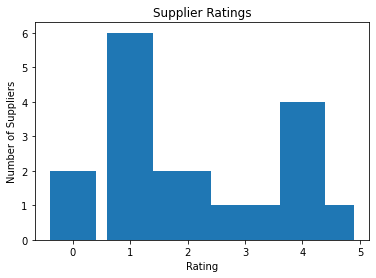

2.125

In [894]:
def calculate_supplier_rating(num_orders_df, delivery_performance):
    if num_orders_df == 0:
        return 0
    elif num_orders_df < 5:
        if delivery_performance == 1:
            return 1
        elif delivery_performance == 2:
            return 1.5
        elif delivery_performance == 3:
            return 2
    elif num_orders_df < 10:
        if delivery_performance == 1:
            return 2.5
        elif delivery_performance == 2:
            return 3
        elif delivery_performance == 3:
            return 3.5
    else:
        if delivery_performance == 1:
            return 4
        elif delivery_performance == 2:
            return 4.5
        elif delivery_performance == 3:
            return 5


suppliers_df['supplier_rating'] = suppliers_df.apply(lambda row: calculate_supplier_rating(row['supplier_num_orders'], row['delivery_performance']), axis=1)


import matplotlib.pyplot as plt

# Count the number of suppliers for each rating
supplier_ratings = suppliers_df['supplier_rating'].value_counts().sort_index()

# Create a bar chart
plt.bar(supplier_ratings.index, supplier_ratings.values)

# Set the chart title and axis labels
plt.title('Supplier Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Suppliers')

# Show the chart
plt.show()

suppliers_df['supplier_rating'].mean()


Realtionship between the Restaurant Cuisine and the pervious ordered products

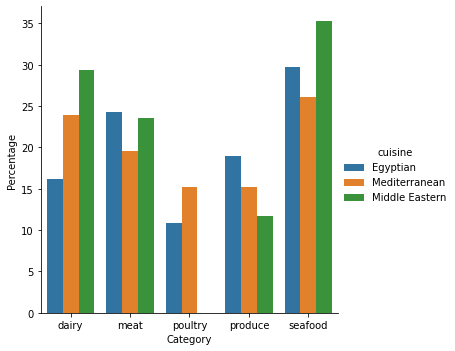

In [895]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Merge the three dataframes
merged_df = orders_df.merge(products_df, on='product_id')
merged_df = merged_df.merge(restaurants_df, on='restaurant_id')

# 2. Group the merged dataframe by cuisine and category, and count the number of orders_df for each combination
grouped_df = merged_df.groupby(['cuisine', 'product_category']).agg({'order_id': 'count'}).reset_index()

# 3. Calculate the total number of orders_df for each cuisine
total_orders_df = grouped_df.groupby('cuisine').agg({'order_id': 'sum'}).reset_index().rename(columns={'order_id': 'total_orders_df'})

# 4. Merge the grouped dataframe with the total orders_df dataframe to get the percentage of orders_df for each category and cuisine
percentage_df = grouped_df.merge(total_orders_df, on='cuisine')
percentage_df['percentage'] = percentage_df['order_id'] / percentage_df['total_orders_df'] * 100

# 5. Create a separate chart for each cuisine using a bar chart with the category on the x-axis and the percentage on the y-axis
sns.catplot(x='product_category', y='percentage', hue='cuisine', kind='bar', data=percentage_df)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()




Product Season


<AxesSubplot:xlabel='product_category'>

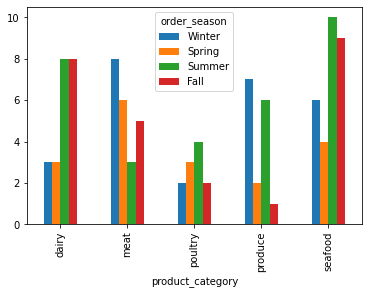

In [896]:
import pandas as pd

# Merge orders and products dataframes
df = pd.merge(orders_df, products_df, on='product_id')

# Create a new column for the order season
df['order_season'] = pd.cut(df['order_month'], [0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Group by product_category and order_season, and count the number of orders
category_season_counts = df.groupby(['product_category', 'order_season'])['order_id'].count().reset_index()

# Pivot the table so that each category is a column
category_season_counts = category_season_counts.pivot(index='product_category', columns='order_season', values='order_id')

# Reorder columns so that they are in the desired order
category_season_counts = category_season_counts[['Winter', 'Spring', 'Summer', 'Fall']]

# Visualize as a bar chart
category_season_counts.plot(kind='bar')




# Training and Testing

# ML

**Future procurement behavior: How much will a restaurant order from a specific supplier in the upcoming month?**


**cross validtion for ForestRandom**

In [897]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Merge the dataframes
df = pd.merge(orders_df, products_df, on='product_id')
df = pd.merge(df, suppliers_df, on='supplier_id')
df = pd.merge(df, restaurants_df, on='restaurant_id')

# Select features and target variable
X = df[['supplier_id', 'restaurant_id']]
y = df['quantity']

# Train the RandomForestRegressor model using cross-validation
model = RandomForestRegressor(n_estimators=50)
scores = cross_val_score(model, X, y, cv=5)

# Print the mean score and the standard deviation
print("Mean absolute error:", -scores.mean())


Mean absolute error: 0.3300889079305816


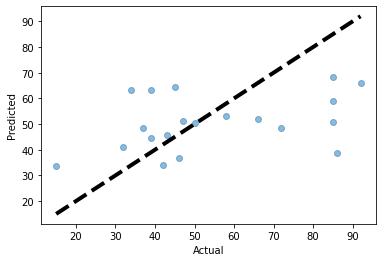

In [898]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


df = pd.merge(orders_df, products_df, on='product_id')
df = pd.merge(df, suppliers_df, on='supplier_id')
df = pd.merge(df, restaurants_df, on='restaurant_id')



X_train, X_test, y_train, y_test = train_test_split(df[['supplier_id', 'restaurant_id']], df['quantity'], test_size=0.2)
errors = []
for i in range(1, 100):
    model = RandomForestRegressor(n_estimators=i)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_absolute_error(predictions, y_test)
    errors.append(error)

max(errors)
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()



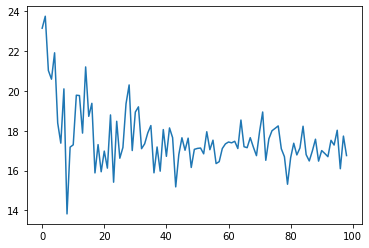

In [899]:
import matplotlib.pyplot as plt
plt.plot(errors)

In [900]:

def get_predction_Q1(rest_id, supp_id):
    rest_name = restaurants_df.loc[restaurants_df['restaurant_id'] == rest_id, 'restaurant_name'].values[0]
    supp_name = suppliers_df.loc[suppliers_df['supplier_id'] == supp_id, 'supplier_name'].values[0]
    prediction = model.predict(np.array([[rest_id, supp_id]]))

    return rest_name, supp_name , prediction




In [901]:
get_predction_Q1(1,2)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


('Gigashots', 'Thoughtmix', array([40.28282828]))

**Supplier performance: How likely is a supplier to meet the expected delivery time for an order?**

DecisionTreeRegressor

MAE 0.0


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


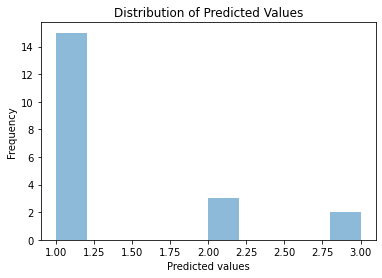

In [902]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.merge(orders_df, products_df, on='product_id')
df = pd.merge(df, suppliers_df, on='supplier_id')
df.drop('phone', axis=1, inplace=True) # inplace=True to modify the dataframe in place

X_train, X_test, y_train, y_test = train_test_split(df[['supplier_id', 'supplier_num_orders', 'supplier_rating']],
                                                     df['delivery_performance'], test_size=0.2)


model = DecisionTreeRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = predictions.astype(float)
error = mean_absolute_error(predictions, y_test) # using R2 instead of MAE

print('MAE',error)

plt.hist(predictions, bins=10, alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Values')
plt.show()




In [903]:
def getExpectedDevliveryTime(supp_id, suppliers_df):
    supplier_info = suppliers_df.loc[suppliers_df['supplier_id'] == supp_id, ['supplier_num_orders', 'supplier_rating']]
    supplier_num_orders = supplier_info.iloc[0]['supplier_num_orders']
    supplier_rating = supplier_info.iloc[0]['supplier_rating']
    predict = model.predict(np.array([[supp_id,supplier_num_orders,supplier_rating]]))
    print(predict)

getExpectedDevliveryTime(1,suppliers_df)




[3.]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


RandomForestRegressor

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


0.051234567901234575


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is de

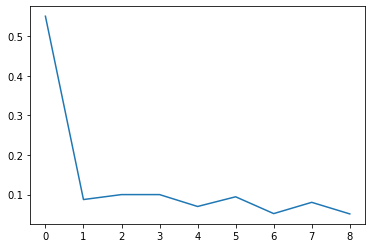

In [904]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = pd.merge(orders_df, products_df, on='product_id')
df = pd.merge(df, suppliers_df, on='supplier_id')
df.drop('phone', axis=1, inplace=True) # inplace=True to modify the dataframe in place

X_train, X_test, y_train, y_test = train_test_split(df[['supplier_id', 'supplier_num_orders', 'supplier_rating', 'delivery_lead_days']],
                                                     df['delivery_performance'], test_size=0.2)

errors = []
for i in range(1, 10):
    model = RandomForestRegressor(n_estimators=i)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(predictions, y_test) # using MSE instead of R2
    errors.append(error)

print(min(errors))
import matplotlib.pyplot as plt
plt.plot(errors)




**Product recommendation: Which products should be recommended to a restaurant based on their procurement history and preferences?**

Prepare the data

In [921]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

df = pd.merge(orders_df, restaurants_df, on='restaurant_id')
df = pd.merge(df, products_df, on='product_id')

df.drop(['manager_id', 'phone_number', 'address', 'created_on', 'product_unit', 'state'], axis=1, inplace=True)

# Encode categorical variables
le = LabelEncoder()
df['product_category'] = le.fit_transform(df['product_category'])
df['cuisine'] = le.fit_transform(df['cuisine'])
df['price_range'] = le.fit_transform(df['price_range'])

# Prepare the data for cross-validation
X = df[['cuisine', 'product_rating', 'restaurant_id', 'product_id']]
y = df['product_name']

# Train the logistic regression model using cross-validation
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=5)

# Print the accuracy scores for each fold and the mean score
print("Accuracy scores:", scores)
print("Mean accuracy score:", scores.mean())


Accuracy scores: [0.15 0.3  0.1  0.2  0.05]
Mean accuracy score: 0.16


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

Cross-Validation for LogisticRegression

In [916]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score



# Train the logistic regression model using cross-validation
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=5)

# Print the accuracy scores for each fold and the mean score
print("Accuracy scores:", scores)
print("Mean accuracy score:", scores.mean()*100,"%")

Accuracy scores: [0.45 0.5  0.25 0.35 0.3 ]
Mean accuracy score: 37.0 %


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

Cross-Validation for KNN

In [917]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=5)

# Print the accuracy scores for each fold and the mean score
print("Accuracy scores:", scores)
print("Mean accuracy score:", scores.mean()*100,"%")

Accuracy scores: [0.25 0.4  0.15 0.3  0.2 ]
Mean accuracy score: 26.0 %


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation for RandomForestCalssifier

In [922]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Train the random forest classifier using 5-fold cross-validation
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=5)

# Print the cross-validation scores and the mean score
print("Cross-validation scores:", scores)
print("Mean accuracy score:", scores.mean()*100,"%")

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.75 0.65 0.65 0.55 0.6 ]
Mean accuracy score: 63.99999999999999 %


Using RandomForesetCalssifier

In [924]:
X_test

,cuisine,product_rating,restaurant_id,product_id
28,0,4,18,21
98,0,3,3,8
49,1,5,7,1
8,1,4,5,43
82,1,2,11,50
81,0,2,8,50
6,1,4,26,7
64,0,4,24,18
92,1,1,19,2
69,0,4,12,37


In [926]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Test the random forest classifier
accuracy = rf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100}%")

predictions = model.predict(X_test)

Accuracy: 55.00000000000001%


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'Spoon - Soup, Plastic'